In [1]:
import sys

sys.path.append('/root/autodl-tmp/I-AM/project/backend/agents')

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_core.runnables import Runnable, RunnableConfig
# from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from typing import List, Optional, Dict, Any, Literal
from pydantic import BaseModel, Field, ConfigDict, field_validator
import json
import yaml
from datetime import datetime
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
with open('/root/autodl-tmp/I-AM/project/backend/config/meditation.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [3]:

llm = ChatOpenAI(model="deepseek-chat", openai_api_key=os.getenv("DEEPSEEK_API_KEY"), openai_api_base='https://api.deepseek.com')

In [4]:
def add_log(current_log, new_log: str) -> list[str]:
    if current_log is None:
        return [new_log]
    elif isinstance(current_log, list):
        return current_log + [new_log]
    elif isinstance(current_log, str):
        return [current_log, new_log]
    else:
        return [new_log]

class OverallState(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)

    messages: List[AnyMessage] = Field(default_factory=list, title="对话列表")
    route: Literal["diary", "meditation", "normal_chat"] = Field(default="normal_chat", title="当前路由")
    log: List[str] = Field(default_factory=list, title="日志列表")

    @field_validator('log', mode='before')
    def validate_log(cls, v, info):
        if v is None or (isinstance(v, list) and len(v) == 0):
            return []
        if 'log' in info.data:
            return add_log(info.data['log'], v)
        return [v] if isinstance(v ,str) else v
        

    @field_validator('messages', mode='before')
    def validate_messages(cls, v, info):
        if 'messages' in info.data:
            return add_messages(info.data['messages'], v)
        else:
            return v if isinstance(v, list) else [v]

## 统一的结果状态类

In [5]:
class NodeResult(OverallState):
    success: bool = Field(default=True, title="执行状态")
    data: Optional[Dict[str, Any]] = Field(default=None, title="详细传递数据")
    error: Optional[str] = Field(default=None, title="错误信息")

## Outline Node

In [6]:
# 定义用户上下文模型
class UserContext(BaseModel):
    main_goal: str = Field(..., title="用户的主要目标或困扰")
    current_state: str = Field(..., title="当前的情绪状态")
    desired_outcome: str = Field(..., title="期望达到的效果")

# 定义脚本段落模型
class ScriptSegment(BaseModel):
    focus: str = Field(..., title="段落主题焦点")
    content_brief: str = Field(..., title="内容简要提示")

# 定义主体引导模型
class MainGuidance(BaseModel):
    segments: List[ScriptSegment] = Field(..., title="主体引导的段落列表")

# 定义完整脚本结构
class ScriptStructure(BaseModel):
    opening: ScriptSegment = Field(..., title="开场部分")
    main_guidance: MainGuidance = Field(..., title="主体引导部分")
    closing: ScriptSegment = Field(..., title="结束部分")

# 定义完整冥想脚本大纲
class MeditationOutline(BaseModel):
    user_context: UserContext = Field(..., title="用户背景信息")
    script_structure: ScriptStructure = Field(..., title="脚本结构")

    @property
    def as_str(self) -> str:
        # 构建用户上下文字符串
        context = (
            f"# 用户背景\n\n"
            f"- 主要目标：{self.user_context.main_goal}\n"
            f"- 当前状态：{self.user_context.current_state}\n"
            f"- 期望效果：{self.user_context.desired_outcome}\n\n"
        )
        
        # 构建脚本结构字符串
        script = (
            f"# 冥想引导词大纲\n\n"
            f"## 开场部分\n"
            f"主题：{self.script_structure.opening.focus}\n"
            f"内容：{self.script_structure.opening.content_brief}\n\n"
            f"## 主体引导\n"
        )
        
        # 添加主体引导的每个段落
        for i, segment in enumerate(self.script_structure.main_guidance.segments, 1):
            script += f"### 第{i}段\n主题：{segment.focus}\n内容：{segment.content_brief}\n\n"
        
        # 添加结束部分
        script += (
            f"## 结束部分\n"
            f"主题：{self.script_structure.closing.focus}\n"
            f"内容：{self.script_structure.closing.content_brief}"
        )
        
        return context + script

with open(config['prompts']['outline'], 'r', encoding='utf-8') as f:
    MEDITATION_OUTLINE_PROMPT = f.read()


def create_meditation_outline(state: NodeResult) -> NodeResult:
    try:
        conversation_content = ""
        for message in state.messages:
            if isinstance(message, HumanMessage):
                conversation_content += f"user: {message.content}\n"
            elif isinstance(message, AIMessage):
                conversation_content += f"assistant: {message.content}\n"
            else:
                continue
        meditation_outline_prompt = ChatPromptTemplate([
            ("system", MEDITATION_OUTLINE_PROMPT),  # 使用你已有的提示词
            ("user", "{conversation_content}")
        ])
        generate_meditation_outline = meditation_outline_prompt | llm.with_structured_output(MeditationOutline)
        outline = generate_meditation_outline.invoke({"conversation_content": conversation_content})

        print("大纲已生成")
        
        return NodeResult(data={"outline": outline.as_str})
    except Exception as e:
        return NodeResult(success=False, error=str(e))

## Script Node

In [7]:

class MeditationScript(BaseModel):
    sequences: List[str] = Field(..., title="引导词序列")

    @property
    def as_str(self) -> str:
        return "\n\n".join(
            f"text: {item}"
            for item in self.sequences
        )

    @property
    def as_yaml(self) -> str:
        return "sequences:\n" + "\n".join(
            f"id: {idx}\ntext: {item}"
            for idx, item in enumerate(self.sequences)
        )

with open(config['prompts']['script'], 'r', encoding='utf-8') as f:
    MEDITATION_SCRIPT_PROMPT = f.read()


def create_meditation_script(state: NodeResult) -> NodeResult:
    try:
        script_prompt = ChatPromptTemplate.from_messages([
            ("system", MEDITATION_SCRIPT_PROMPT),
            ("user", """请根据以下冥想大纲生成详细的引导词：

        {outline}""")
        ])
        generate_meditation_script = script_prompt | llm.with_structured_output(MeditationScript)
        script = generate_meditation_script.invoke({"outline": state.data['outline']})

        print("脚本已生成")
        
        return NodeResult(data={"script": script.as_str})
    except Exception as e:
        return NodeResult(success=False, error=str(e))


## Tone Marking Node

In [8]:

# 定义带标记的文本段落
class MarkedSequence(BaseModel):
    original_text: str = Field(..., title="原始文本")
    marked_text: str = Field(..., title="带标记的文本")
    duration: int = Field(..., title="持续时间（秒）", ge=2, le=6)

# 定义完整的带标记冥想脚本
class MarkedMeditationScript(BaseModel):
    sequences: List[MarkedSequence] = Field(..., title="带标记的引导词序列")

    @property
    def as_str(self) -> str:
        return "\n\n".join(
            f"id: {idx}\ntext: {item.marked_text}\nduration: {item.duration}"
            for idx, item in enumerate(self.sequences)
        )
    
    @property
    def as_yaml(self) -> str:
        return "sequences:\n" + "\n".join(
            f"id: {idx}\ntext: \"{item.marked_text}\"\nduration: {item.duration}"
            for idx, item in enumerate(self.sequences)
        )

    def to_yaml_dict(self) -> dict:
        return {
            "sequences": [
                {
                    "id": idx,
                    "text": item.marked_text,
                    "duration": item.duration
                }
                for idx, item in enumerate(self.sequences)
            ]
        }

with open(config['prompts']['tone'], 'r', encoding='utf-8') as f:
    MEDITATION_TONE_PROMPT = f.read()



def create_marked_meditation_script(state: NodeResult) -> NodeResult:
    try:
        tone_marking_prompt = ChatPromptTemplate.from_messages([
            ("system", MEDITATION_TONE_PROMPT),
            ("user", "请为以下冥想引导词添加适当的语气标记：\n\n{script}")
        ])
        generate_marked_script = tone_marking_prompt | llm.with_structured_output(MarkedMeditationScript)
        marked_script = generate_marked_script.invoke({"script": state.data['script']})
        with open('output/script/exam.yaml', 'w', encoding='utf-8') as f:
            yaml.dump(marked_script.to_yaml_dict(), f, indent=2, allow_unicode=True, sort_keys=False)

        print("带标记的脚本已生成")
        
        return NodeResult(data=marked_script.to_yaml_dict())
    except Exception as e:
        return NodeResult(success=False, error=str(e))



## tts Node

In [9]:
from meditation_tts import CosyVoice2TTS

def create_tts(state: NodeResult) -> NodeResult:
    try:
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        output_path = f"{config['tts']['tts_output_path']}/{timestamp}.wav"
        tts = CosyVoice2TTS(
            model_path=config['tts']['tts_model_path'],
            prompts_config_path=config['tts']['tts_resources_config']
        )
        tts.generate_audio(
            texts=state.data,
            voice_type="female1",
            background_music_type="bmusic_02",
            output_path=output_path
        )  

        print("音频已生成")
        
        return NodeResult(route="meditation", log=f"音频已生成. path: {output_path}")
    except Exception as e:
        return NodeResult(success=False, error=str(e))


2025-01-15 11:28:39,025 - modelscope - INFO - PyTorch version 2.5.1 Found.
2025-01-15 11:28:39,029 - modelscope - INFO - Loading ast index from /root/.cache/modelscope/ast_indexer
2025-01-15 11:28:39,082 - modelscope - INFO - Loading done! Current index file version is 1.15.0, with md5 2f5eeacd95c207bb2bc0f708cda0b4fd and a total number of 980 components indexed
/root/miniconda3/envs/manifest_app/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


failed to import ttsfrd, use WeTextProcessing instead


## 错误处理节点

In [10]:
def handle_error(state: NodeResult) -> NodeResult:  # 修改返回类型标注
    error_msg = state.error
    print(f"处理错误: {error_msg}")
    # 返回正确的 NodeResult 对象
    return NodeResult(
        success=False,
        error=error_msg,
        data={"error_message": f"处理错误: {error_msg}"}
    )

## 条件边判断

In [11]:
def check_success(state: NodeResult):
    if state.success:
        return "success_node"
    else:
        return "error_node"


In [12]:
meditation_workflow = StateGraph(NodeResult)
meditation_workflow.add_node("outline_node", create_meditation_outline)
meditation_workflow.add_node("script_node", create_meditation_script)
meditation_workflow.add_node("tone_marking_node", create_marked_meditation_script)
meditation_workflow.add_node("tts_node", create_tts)
meditation_workflow.add_node("error_node", handle_error)

meditation_workflow.add_conditional_edges(
    "outline_node",
    check_success,
    {
        "success_node": "script_node",
        "error_node": "error_node"
    }
)

meditation_workflow.add_conditional_edges(
        "script_node",
        check_success,
        {
            "success_node": "tone_marking_node",
            "error_node": "error_node"
        }
    )
    
meditation_workflow.add_conditional_edges(
    "tone_marking_node",
    check_success,
    {
        "success_node": "tts_node",
        "error_node": "error_node"
    }
)

meditation_workflow.add_conditional_edges(
    "tts_node",
    check_success,
    {
        "success_node": END,
        "error_node": "error_node"
    }
)
meditation_workflow.add_edge(START, "outline_node")
meditation_workflow.add_edge("error_node", END)

meditation_graph = meditation_workflow.compile()

2025-01-15 11:28:51,452 DEBUG Starting new HTTPS connection (1): mermaid.ink:443
2025-01-15 11:28:52,089 DEBUG https://mermaid.ink:443 "GET /img/JSV7aW5pdDogeydmbG93Y2hhcnQnOiB7J2N1cnZlJzogJ2xpbmVhcid9fX0lJQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCW91dGxpbmVfbm9kZShvdXRsaW5lX25vZGUpCglzY3JpcHRfbm9kZShzY3JpcHRfbm9kZSkKCXRvbmVfbWFya2luZ19ub2RlKHRvbmVfbWFya2luZ19ub2RlKQoJdHRzX25vZGUodHRzX25vZGUpCgllcnJvcl9ub2RlKGVycm9yX25vZGUpCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiBvdXRsaW5lX25vZGU7CgllcnJvcl9ub2RlIC0tPiBfX2VuZF9fOwoJb3V0bGluZV9ub2RlIC0uICZuYnNwO3N1Y2Nlc3Nfbm9kZSZuYnNwOyAuLT4gc2NyaXB0X25vZGU7CglvdXRsaW5lX25vZGUgLS4tPiBlcnJvcl9ub2RlOwoJc2NyaXB0X25vZGUgLS4gJm5ic3A7c3VjY2Vzc19ub2RlJm5ic3A7IC4tPiB0b25lX21hcmtpbmdfbm9kZTsKCXNjcmlwdF9ub2RlIC0uLT4gZXJyb3Jfbm9kZTsKCXRvbmVfbWFya2luZ19ub2RlIC0uICZuYnNwO3N1Y2Nlc3Nfbm9kZSZuYnNwOyAuLT4gdHRzX25vZGU7Cgl0b25lX21hcmtpbmdfbm9kZSAtLi0+IGVycm9yX25vZGU7Cgl0dHNfbm9kZSAtLiAmbmJzcDtzdWNjZXNzX25vZGUmbmJzcDsgLi0

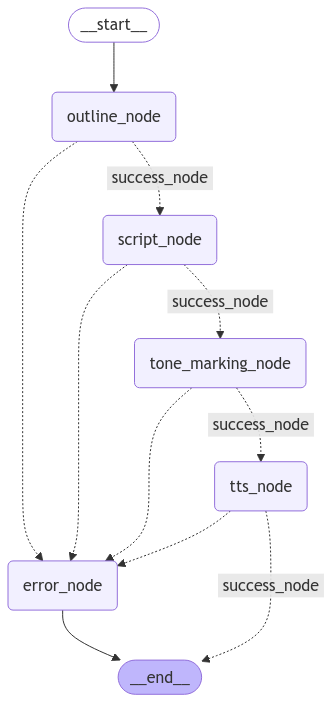

In [13]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(meditation_graph.get_graph(xray=2).draw_mermaid_png()))

In [14]:
import json

# with open('/root/autodl-tmp/I-AM/project/backend/agents/jupyter/conversations_data/meditation.json', 'r', encoding='utf-8') as f:
#     conversation_json = json.load(f)

# conversation = ""
# for message in conversation_json['messages']:
#     conversation += f"{message['role']}: {message['content']}\n"

messags = [
    HumanMessage(content="想要一个2分钟鼓励我，让我充满自信的音频"),
]


meditation_graph.invoke(NodeResult(messages=messags))

2025-01-15 11:28:54,184 DEBUG Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': '你是一位专业的冥想引导师，现在需要你根据用户的对话内容，生成一个冥想引导词的结构化大纲。\n\n请遵循以下要求：\n1. 分析用户对话中的以下关键信息：\n   - 用户的主要困扰或目标\n   - 当前的情绪状态\n   - 期望达到的效果\n   - 偏好的冥想时长（如未指定，默认为5分钟）\n\n2. 生成一个 JSON 格式的冥想脚本大纲，包含以下结构：\n   - 用户背景信息 (user_context)\n   - 脚本结构 (script_structure)，包含：\n     * 开场部分 (opening)：帮助用户进入状态\n     * 主体引导 (main_guidance)：2-4个重点段落\n     * 结束部分 (closing)：帮助用户回到当下\n\n3. 每个部分都需要包含：\n   - 段落主题焦点\n   - 简要内容提示\n\n请根据用户的对话内容，生成一个适合的冥想引导大纲。', 'role': 'system'}, {'content': 'user: 想要一个2分钟鼓励我，让我充满自信的音频\n', 'role': 'user'}], 'model': 'deepseek-chat', 'n': 1, 'parallel_tool_calls': False, 'stream': False, 'temperature': 0.7, 'tool_choice': {'type': 'function', 'function': {'name': 'MeditationOutline'}}, 'tools': [{'type': 'function', 'function': {'name': 'MeditationOutline', 'description': '', 'parameters': {'properties': {'user_context': {'allOf': [{'properties': {'ma

大纲已生成


2025-01-15 11:29:04,223 DEBUG receive_response_body.complete
2025-01-15 11:29:04,225 DEBUG response_closed.started
2025-01-15 11:29:04,227 DEBUG response_closed.complete
2025-01-15 11:29:04,228 DEBUG HTTP Response: POST https://api.deepseek.com/chat/completions "200 OK" Headers({'server': 'nginx', 'date': 'Wed, 15 Jan 2025 03:28:58 GMT', 'content-type': 'application/json', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'vary': 'origin, access-control-request-method, access-control-request-headers', 'access-control-allow-credentials': 'true', 'x-ds-trace-id': 'ce5d1edacf1b4b6effc4ae599b72712a', 'strict-transport-security': 'max-age=31536000; includeSubDomains; preload', 'x-content-type-options': 'nosniff'})
2025-01-15 11:29:04,230 DEBUG request_id: None
2025-01-15 11:29:04,267 DEBUG Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': '你是一位专业的冥想引导词编辑，擅长为冥想引导词添加适当的语气标记。\n\n请遵循以下规则为冥想引导词添加标记：\n\n1. 呼吸标记：\n   - [

脚本已生成


2025-01-15 11:29:17,557 DEBUG receive_response_body.complete
2025-01-15 11:29:17,559 DEBUG response_closed.started
2025-01-15 11:29:17,560 DEBUG response_closed.complete
2025-01-15 11:29:17,562 DEBUG HTTP Response: POST https://api.deepseek.com/chat/completions "200 OK" Headers({'server': 'nginx', 'date': 'Wed, 15 Jan 2025 03:29:04 GMT', 'content-type': 'application/json', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'vary': 'origin, access-control-request-method, access-control-request-headers', 'access-control-allow-credentials': 'true', 'x-ds-trace-id': 'b9e9a2d30204b2471609838e3c8ff666', 'strict-transport-security': 'max-age=31536000; includeSubDomains; preload', 'x-content-type-options': 'nosniff'})
2025-01-15 11:29:17,564 DEBUG request_id: None


带标记的脚本已生成


/root/miniconda3/envs/manifest_app/lib/python3.11/site-packages/diffusers/models/lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
2025-01-15 11:29:31,754 INFO input frame rate=25
/root/miniconda3/envs/manifest_app/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/root/autodl-tmp/I-AM/CosyVoice/cosyvoice/dataset/processor.py:24: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend('soundfile')
Special tokens have been added in the vocabulary, make sure the as

Attempt 1 of 3


Generating audio segments:   0%|          | 0/11 [00:00<?, ?it/s]2025-01-15 11:30:06,579 INFO synthesis text 让我们开始这段<strong>增强自信</strong>的冥想旅程。请找一个安静舒适的地方坐下。
2025-01-15 11:30:14,333 INFO yield speech len 9.44, rtf 0.8213912026356843
Generating audio segments:   9%|▉         | 1/11 [00:09<01:32,  9.29s/it]2025-01-15 11:30:15,308 INFO synthesis text 轻轻闭上眼睛,将注意力集中在你的呼吸上。深吸一口气[breath],感受空气进入你的身体。
2025-01-15 11:30:25,804 INFO yield speech len 11.8, rtf 0.8894966214390124
Generating audio segments:  18%|█▊        | 2/11 [00:20<01:35, 10.57s/it]2025-01-15 11:30:27,257 INFO synthesis text 慢慢呼气[breath],感受身体的放松。让每一次呼吸都带走你的紧张和焦虑。
2025-01-15 11:30:36,282 INFO yield speech len 10.28, rtf 0.8779953657885007
Generating audio segments:  27%|██▋       | 3/11 [00:31<01:24, 10.53s/it]2025-01-15 11:30:37,236 INFO synthesis text 现在,将注意力转移到你的身体上。从头顶开始[breath],慢慢放松每一块肌肉[breath]。
2025-01-15 11:30:47,358 INFO yield speech len 10.0, rtf 1.012178659439087
Generating audio segments:  36%|███▋      | 4/11 [00:42<0

Combining audio segments with background music...
Saving final audio to /root/autodl-tmp/I-AM/project/backend/agents/output/tts/20250115112917.wav
Audio generation completed!
音频已生成


{'messages': [],
 'route': 'meditation',
 'log': ['音频已生成. path: /root/autodl-tmp/I-AM/project/backend/agents/output/tts/20250115112917.wav'],
 'success': True,
 'data': {'sequences': [{'id': 0,
    'text': '让我们开始这段<strong>增强自信</strong>的冥想旅程。请找一个安静舒适的地方坐下。',
    'duration': 2},
   {'id': 1,
    'text': '轻轻闭上眼睛，将注意力集中在你的呼吸上。深吸一口气[breath]，感受空气进入你的身体。',
    'duration': 2},
   {'id': 2, 'text': '慢慢呼气[breath]，感受身体的放松。让每一次呼吸都带走你的紧张和焦虑。', 'duration': 2},
   {'id': 3,
    'text': '现在，将注意力转移到你的身体上。从头顶开始[breath]，慢慢放松每一块肌肉[breath]。',
    'duration': 2},
   {'id': 4,
    'text': '感受你的肩膀[breath]、手臂[breath]、胸部[breath]和腹部[breath]逐渐放松。让整个身体都沉浸在平静中。',
    'duration': 2},
   {'id': 5,
    'text': "接下来，我们将进行<strong>自我肯定</strong>。请在心里默念：'我充满自信'。",
    'duration': 2},
   {'id': 6,
    'text': "重复这句话：'我有能力应对任何挑战'。感受这些话语带来的<strong>力量和信心</strong>。",
    'duration': 2},
   {'id': 7,
    'text': '现在，想象自己成功完成了一个重要目标。看到自己<strong>自信满满</strong>地站在那里。',
    'duration': 2},
   {'id': 8,
    'text': '感受那种<strong>自信和满足感